<a href="https://colab.research.google.com/github/marie-ganon/Projet-Python-S1/blob/main/Statistiques_descriptives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chargement des packages et de la base

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
from wordcloud import WordCloud, STOPWORDS 
import csv
import bs4
from tqdm.notebook import trange, tqdm
import seaborn as sns
import numpy as np
import zipfile
import tempfile

In [ ]:
temp_dir = tempfile.mkdtemp()

with zipfile.ZipFile('base.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_dir')

df = pd.read_csv(r'temp_dir/base.csv', sep=',', low_memory = False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:



ValueError: ignored

In [94]:
 df = pd.read_csv('https://raw.githubusercontent.com/marie-ganon/Projet-Python-S1/main/base.csv')

Dans ce notebook, nous allons réaliser des statistiques descriptives variées sur le contenu de notre base.

#### Sommaire
1. Quelques généralités sur les variables
2. Statistiques sur la variable *genre*
3. Statistiques sur le budget
4. Statistiques sur le revenu
5. Statistique sur les mots-clés
    - Récupération de la base et premier nuage de mots
    - Apparition des mots-clés en fonction du genre
    - Score et mots-clés
6. Statistique sur le résumé
    - Détermination des mots fréquement utilisés dans les meilleurs films
        - Par LDA
        - via ACP (?)



# Quelques généralités

Avant de commencer, on peut essayer d'observer pour la base nettoyée la matrice des corrélations afin d'avoir une idée des liens entre les différentes variables.

On peut noter qu'on s'attend à ce que *score_1* soit corrélé fortement à *vote_average* et *vote_count* par construction. 

In [ ]:
 corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

La matrice de corrélation ne nous apporte pas énormément d'information. On peut essayer de voir sur le subset complet du dataset. 

In [ ]:
corr = df.dropna().corr()
corr.style.background_gradient(cmap = 'coolwarm')

# Statistiques sur la variable *genre*

On créé un data frame comportant tous les genres de films présents dans la base.

In [101]:
l = []
for i in trange(len(df)):
    genre = str(df.genres[i]).split()
    for j in genre :
        l.append(j)

      
df_genre = pd.DataFrame(l, columns=['genre'])
# Traitement des 'nan' et des ''
df_genre = df_genre[df_genre.genre != 'nan']
df_genre.genre = df_genre.genre.str.replace(r',', '')
df_genre = df_genre[df_genre.genre != 'name']
liste_genre = list(df_genre.genre.unique())
df_genre = df_genre[df_genre.genre != liste_genre[20]]

In [100]:
df_genre.genre.unique()

array(['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History',
       'Science', 'War', 'Mystery', 'Foreign', 'Music', 'Documentary',
       'Western', 'TV', ''], dtype=object)

Text(0.5, 1.0, 'Occurrences des genres sur la base complète')

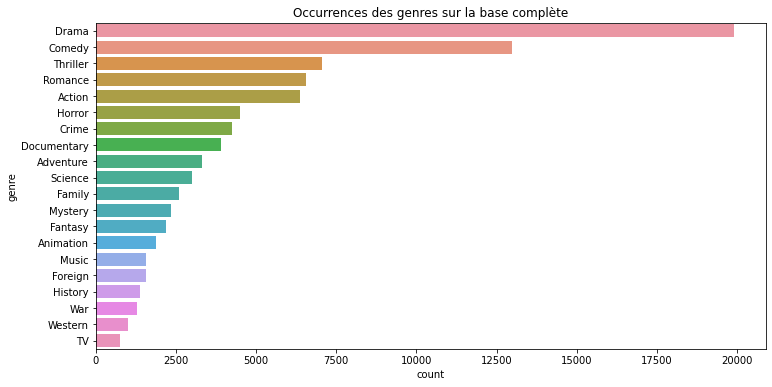

In [102]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(y = df_genre.genre, order = df_genre['genre'].value_counts().index)
plt.title('Occurrences des genres sur la base complète')

Le graphique ci-dessus nous informe que les deux genres les plus représentés dans la base sont les comédies et les drames. Ce résultat est assez logique car ces types de films sont souvent donnés en complément d'un autre genre. A présent, étudions les films les mieux classés.

In [ ]:
df.vote_count

0        5415.0
1        2413.0
2          92.0
3          34.0
4         173.0
          ...  
42975       1.0
42976      26.0
42977       1.0
42978       3.0
42979       6.0
Name: vote_count, Length: 42980, dtype: float64

En regardant de plus près la variable *vote_count*, nous constatons que certains films comportent moins de 10 évaluations. Par conséquent, afin d'avoir une analyse plus fine de la base, nous allons étudier les genres les plus représentés sur les films les mieux notés selon le classement imdb, sous contrainte que suffisamment de personnes les aient évalués (plus de 100).

On construit donc "best movies" correspondant aux films ayant été notés par plus de 100 personnes et ayant une note supérieure à 7.0 qu'on compare à l'ensemble des films ayant été notés par plus de 100 personnes. 

In [103]:
df_classement =df[df.vote_count>100].sort_values(by='vote_average', ascending = False)     # on filtre sur les films qui ont été notés au moins 100 fois
df_best_movies = df_classement[df_classement.genres != '']    # on filtre sur les films pour lesquels le genre est renseigné
df_best_movies = df_best_movies[df.vote_average >= 7.0]      # on filtre sur les "meilleurs films" ie avec un score supérieur à 7
df_best_movies.reset_index(drop = True)
print('La base contient',len(df_best_movies),'films très bien notés (>= 7.0)')

La base contient 1759 films très bien notés (>= 7.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [113]:
l = []
for i in trange(len(df_best_movies)):
    if type(df_best_movies.genres.iloc[i]) == str :
        bm_genre = df_best_movies.genres.iloc[i].split()
        for i in bm_genre :
            l.append(i)
print(len(l))
df_bm_genre = pd.DataFrame(l, columns=['genre'])
df_bm_genre.genre = df_bm_genre.genre.str.replace(r',', '')
df_bm_genre['best_movies']=['Best movies' for i in range(len(df_bm_genre))]
df_genre['best_movies']=['All movies' for i in range(len(df_genre))]
# Traitement des ''
df_bm_genre = df_bm_genre[df_bm_genre.genre != 'name']
liste_genre = list(df_bm_genre.genre.unique())
df_bm_genre = df_bm_genre[df_bm_genre.genre != liste_genre[19]]


4372


In [115]:
df_compare_genres = df_genre.append(df_bm_genre)


Text(0.5, 1.0, 'Occurrences des genres des films les mieux notés vs occurrences de tous les genres ')

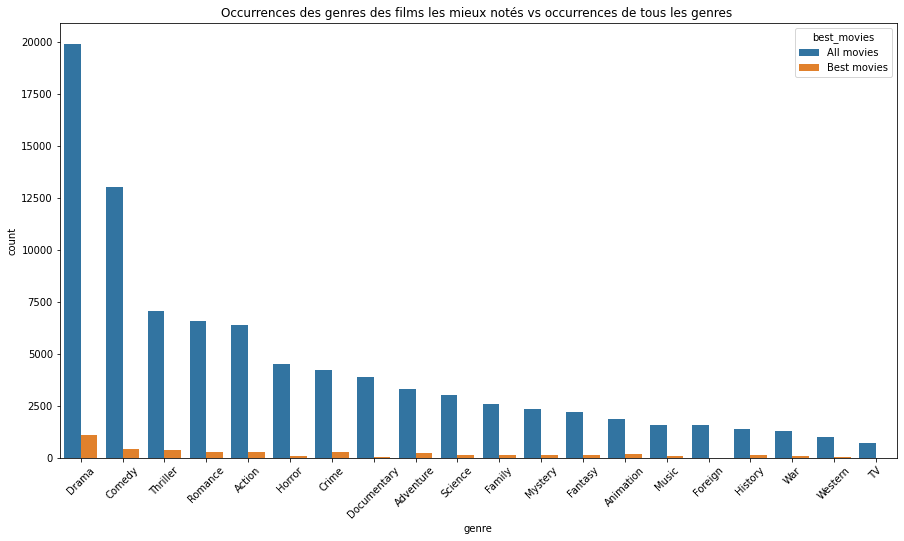

In [116]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(x='genre', hue='best_movies', data=df_compare_genres, order=df_genre.genre.value_counts(normalize=True).index)
plt.xticks(rotation=45)
plt.title('Occurrences des genres des films les mieux notés vs occurrences de tous les genres ')

Un plot des observations des genres des films les mieux notés contre ceux de tous les films ne nous permet pas de conclure. On normalise donc tout cela pour faire apparaître la fréquence d'apparition des genres pour l'ensemble des films et pour les films les mieux notés. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

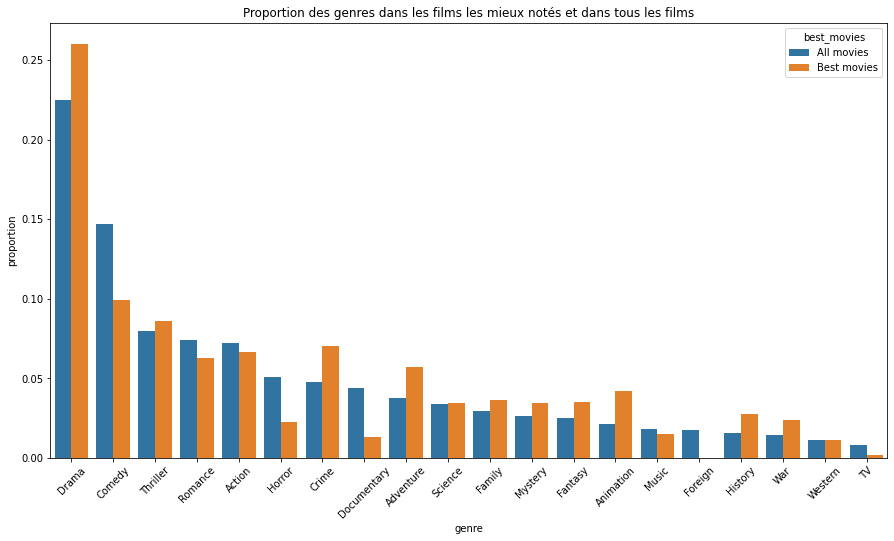

In [117]:
fig, ax = plt.subplots(figsize=(15,8))
x, y, hue = "genre", "proportion", "best_movies"
(df_compare_genres[x].groupby(df_compare_genres[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))
plt.title('Proportion des genres dans les films les mieux notés et dans tous les films')
plt.xticks(rotation=45)

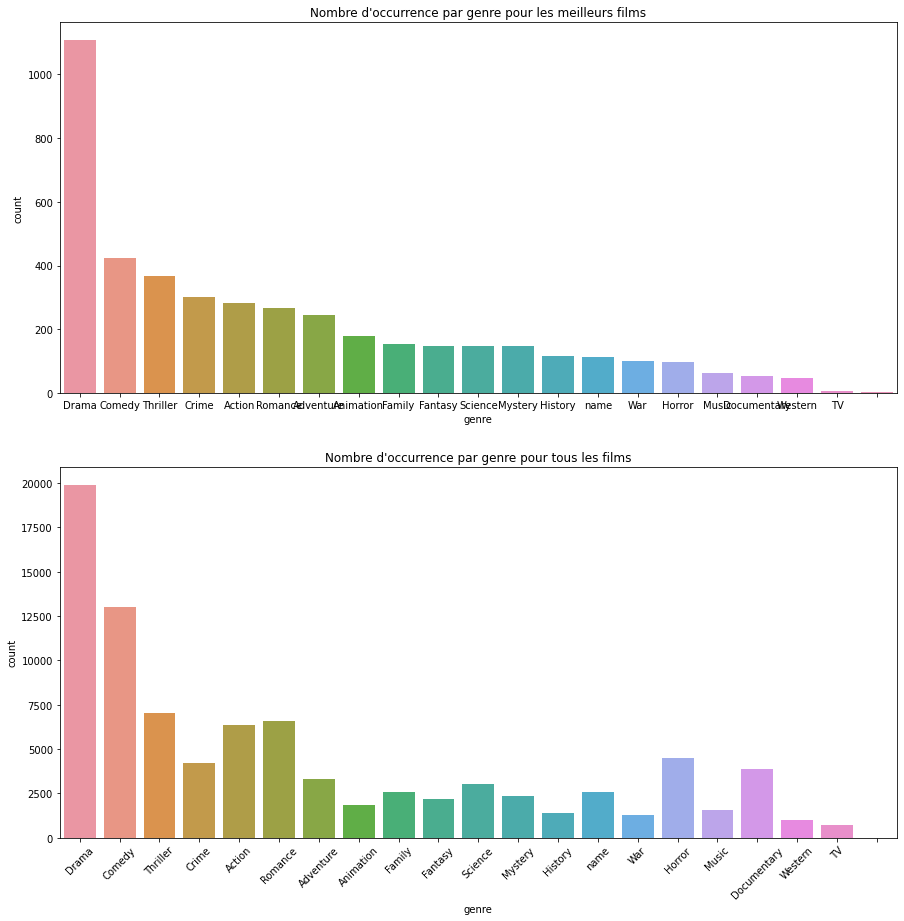

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(2, figsize=(15,15))
sns.countplot(x = df_bm_genre.genre, order = df_bm_genre.genre.value_counts().index, ax = ax_1)
plt.xticks(rotation=45)
sns.countplot(x = df_genre.genre, order = df_bm_genre.genre.value_counts().index,ax=ax_2)
ax_1.title.set_text("Nombre d'occurrence par genre pour les meilleurs films")
ax_2.title.set_text("Nombre d'occurrence par genre pour tous les films")

Nous remarquons que la tendance est sensiblement la même. En effet, avec environ plus de 18 000 films dramatiques, il est assez normal de trouver un bon nombre de films bien notés dans cet ensemble.

Toutefois, on constate que bien que certains genres de films soient très présents dans la base, ils peuvent apparaître moins souvent dans le classement des meilleurs films. 

En effet, alors que le genre Romance était le 3ème genre le plus présent, ici nous remarquons qu'il apparaît beaucoup plus loin dans le classement des genres les plus représentés dans les films les mieux notés (6e position). A l'inverse, le genre Crime est le 4 ème genre le plus représenté dans l'échantillon, et gagne alors 2 places par rapport à son classement dans l'échantillon initial.

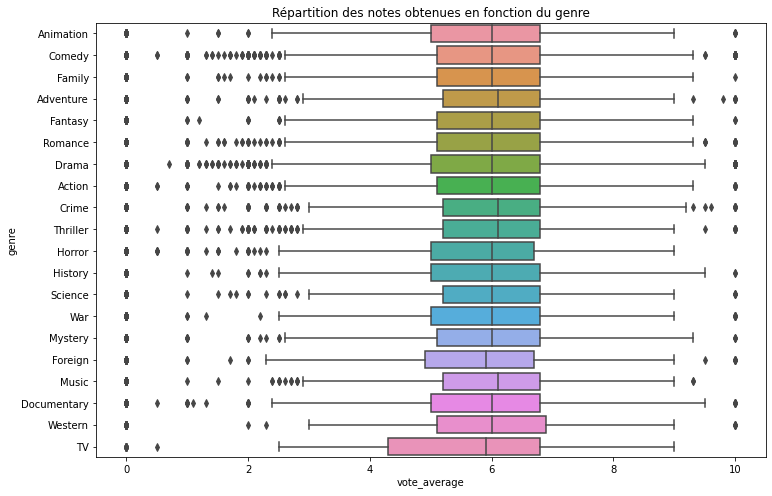

In [118]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=df_genre.genre, x = df.vote_average)
ax.title.set_text('Répartition des notes obtenues en fonction du genre')

Globalement, la répartition des notes est la même pour chaque genre de film. Néanmoins, *vote_average* étant biaisé, on peut observer sur le *score_1* (succès critiques). On enlève les outliers pour pouvoir observer les données. 

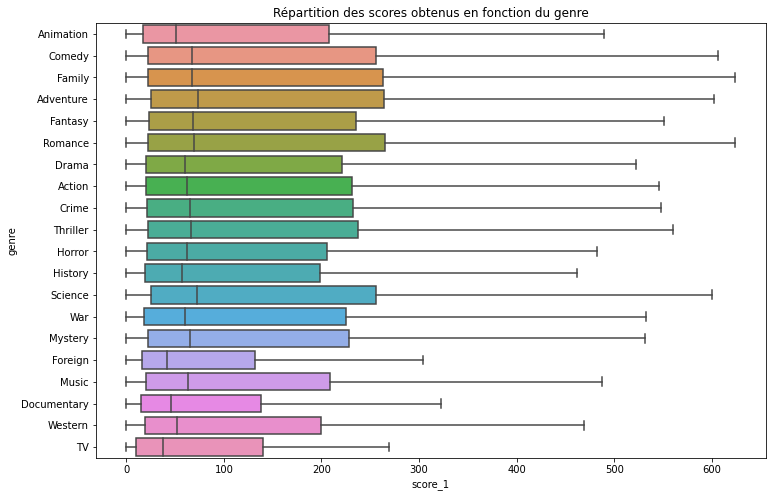

In [119]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=df_genre.genre, x = df.score_1, showfliers=False)
ax.title.set_text('Répartition des scores obtenus en fonction du genre')

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=df_genre.genre, x = df.popularity, showfliers=False)
ax.title.set_text('Répartition de la popularité obtenue en fonction du genre')

La répartition change un petit peu : sans pouvoir déterminer clairement un genre pour lequel le score est plus élevé, on peut noter que les films des genres suivant bénéficient de scores plus faibles : *foreign*, *documentary* ou *tv*. 

In [ ]:
df.columns

Index(['Unnamed: 0', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'release_date', 'revenue',
       'runtime', 'status', 'title', 'vote_average', 'vote_count',
       'collection', 'score_1', 'production_companies_name',
       'production_companies_id', 'pc_id_count', 'country_code',
       'country_name', 'score_normalise'],
      dtype='object')

# Statistiques sur le budget

Une simple recherche internet nous informe que les budgets les plus petits dans la conception d'un film (appelés films "micro-budgets") s'élèvent à quelques milliers de dollars. On peut regarder la distribution des films micro-budgets.

In [120]:
len(df.budget[df.budget == 0])/len(df.budget)*100

79.47650069799906

In [121]:
df.budget[df.budget < 10000].describe()

count    34448.000000
mean         8.365769
std        205.607713
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9500.000000
Name: budget, dtype: float64

Ainsi, en moyenne, les films micro-budgets (budget inférieur à 10000 dollars) ont eu 8 dollars de budget.

In [124]:
fig, ax = plt.subplots(figsize=(12,6))
df.budget[df.budget < 10000].hist()
plt.title('Histogramme des films à budgets inférieurs à 10 000 dollars (microfilms)')

print('Pourcentage de microfilms (budget inférieur à 10000 dollars) à budget inférieurs à 1000 dollars : \n', (len(df.budget[df.budget < 1000])/len(df.budget[df.budget < 10000]))*100,'%')

Pourcentage de microfilms (budget inférieur à 10000 dollars) à budget inférieurs à 1000 dollars : 
 99.84904784022295 %


Au sein des microfilms, on compte 99.85% de films à budget inférieur à 1000 euros. Ce nombre est de fait assez suspect, on peut imaginer que la base contient des 0 pour les valeurs de budget inconnues ainsi que la plupart des nombres entre 0 et 1000 dollars de production sont des outliers dûs à des erreurs de saisies. 

In [125]:
df_budget_ecrete = df.budget[df.budget > 10000]
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(df_budget_ecrete)
#ax.set_xscale('log')
#ax.set_yscale('log')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



L'information sur le budget paraît peu exploitable. Par conséquent, nous allons nous intéresser plus en détails aux revenus générés par le film.

# Statistiques sur les revenus

Etudions tout d'abord la proportion de films n'ayant généré aucun revenu:

In [126]:
len(df.revenue[df.revenue == 0])/len(df.revenue)*100

82.83387622149837

Ainsi, plus de 83% des films de la base n'ont généré aucun revenu.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



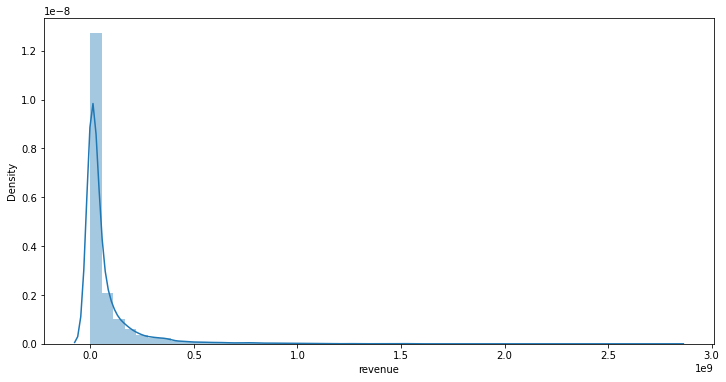

In [127]:
df_revenue_ecrete = df.revenue[df.revenue > 10000]
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(df_revenue_ecrete)
#ax.set_xscale('log')
#ax.set_yscale('log')

A travers ce graphique, on constate que la proportion de films à gros budget est très faible. De fait, nous ne pourrons pas non plus exploiter cette variable pour la modélisation. 

Comme *budget* et *revenue* sont mal renseignés, mais que ce sont des variables qui semblent être corrélées à la popularité/succès des films, on pourra se pencher dessus dans la partie de modélisation. 

# Statistiques sur les mots-clés

## Récupération de la base et premier nuage de mots

In [ ]:
!ls

base.csv.zip  base_keywords2.csv.zip  sample_data  temp_dir


In [ ]:
with zipfile.ZipFile('base_keywords2.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_dir')

In [ ]:
df_2 = pd.read_csv('temp_dir/base_keywords2.csv', sep=';', encoding = 'utf-8', nrows=45466, low_memory = False)
df_2

Unnamed: 0  ... Unnamed: 4
0              0  ...        NaN
1              1  ...        NaN
2              2  ...        NaN
3              3  ...        NaN
4              4  ...        NaN
...          ...  ...        ...
45461      45355  ...        NaN
45462      45356  ...        NaN
45463      45357  ...        NaN
45464      45358  ...        NaN
45465      45359  ...        NaN

[45466 rows x 5 columns]

A l'aide du package *wordcloud*, nous allons pouvoir créer des nuages de mots. Dans la fonction ci-dessous, nous avons anticipé pour supprimer des mots-clés qui n'étaient pas en rapport direct avec le scénario du film, par exemple le studio d'animation Ghibli ou le fait que le film soit culte.

In [ ]:
def nuage_de_mots(text): 
    wordcloud = WordCloud(background_color="white",
                          relative_scaling = 1.0,
                          width=1280, 
                          height=800, 
                          stopwords = {'on', 'in', 'at', 'the', 'to', 'of', 'by', '_None', '_', 'NoNe', 'studio_ghibli', 'dc_comic', 'cult_film', 'neo_noir', 'black_comedy', 'dc_comics'} # mots à ne pas prendre en compte dans le nuage
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()    

Pour produire des nuages de mots qualitatifs, nous nous sommes rendu compte qu'il faut que l'algorithme puisse comprendre que chaque élément de *df_2.keywords[i]* correspond à un seul et unique mot-clé. Autrement, nous pourrions voir apparaître dans le nuage de mots à la fois 'new york' et 'york city'.

Par conséquent, nous allons traiter les données de manière astucieuse en utilisant plusieurs fois str.replace :

In [ ]:
print(df_2.keywords[0])

# On enlève les crochets et virgules et on les remplace par des tirets pour bien distinguer les mots-clés
df_2.keywords = df_2.keywords.str.replace(r'[^\w\s]', '-')
print(df_2.keywords[0])

# Les seuls espaces possibles se trouvent au sein d'un même mot-clé ou bien entre deux mots-clés distincts
df_2.keywords=df_2.keywords.str.replace(' ', '_')
print(df_2.keywords[0])

# On supprime les '-_-' qui ont été créés suite aux deux étapes précédentes
df_2.keywords = df_2.keywords.str.replace('-_-', '')
print(df_2.keywords[0])

# Désormais, les tirets sont la seule marque de ponctuation inutile
df_2.keywords = df_2.keywords.str.replace('-', ' ')
print(df_2.keywords[0])


Il ne reste plus qu'à concaténer tous les mots-clés pour pouvoir lancer la fonction nuage_de_mots précédente.

In [ ]:
mots_cles = ''
for i in trange(len(df_2)):
  mots_cles = mots_cles + str(df_2.keywords[i])

In [ ]:
mots_cles

Puis on affiche le nuage de mots correspondant à tous ces mots-clés.

In [ ]:
nuage_de_mots(mots_cles)

Le nuage de mots ci-dessus retranscrit le nombre d'apparitions des mots-clés dans la base entière. Les trois mots qui correspondent au plus grand nombre de films sont 'violence', 'mort' et 'assassinat'. Cependant, si ces mots apparaissent souvent, c'est parce qu'ils se retrouvent dans de nombreuses catégories, telles que Thriller, Action, Horreur et Drame. Par conséquent, pour avoir plus de précisions sur la fréquence d'apparition des mots-clés, nous allons nous intéresser à ceux qui reviennent le plus au sein des meilleurs films d'un genre

## Apparition des mots-clés en fonction du genre

Nous disposons déjà de la liste des genres de films qui composent la base :

In [ ]:
liste_genre = list(df_genre.genre.unique())
liste_genre.remove(liste_genre[13])
liste_genre.remove('nan')
liste_genre

Nous pouvons désormais récupérer les mots-clés dans un dictionnaire qui a pour clés les différents genres.

In [ ]:
dico_nuages = dict()
for movie_genre in tqdm(liste_genre):
  liste_movie_genre = ''
  for i in range (len(df_best_movies)):
    if str(movie_genre) in str(df_best_movies.genres.iloc[i]):
      keywords_movie = df_2.keywords[df_2.imdb_id == df_best_movies.imdb_id.iloc[i]]    # on récupère les mots-clés associés au film i du genre movie_genre 
      l = keywords_movie.to_string()                                                    # on doit convertir cette serie en string de la forme 'i   mots-clés'
      ll = l.split()
      if len(ll) > 1 :                                                                  # on vérifie que le film contient bien des mots-clés
        kw = ' '.join(ll[1:])                                                           # on convertit la liste précédemment créée en string
        liste_movie_genre += kw                                                         # on ajoute kw à la liste des mots-clés du genre
  dico_nuages[str(movie_genre)] = liste_movie_genre

In [ ]:
for key in dico_nuages:
  if str(key) != 'Foreign':
    print('Nuage de mots pour le genre', key)
    nuage_de_mots(dico_nuages[str(key)])

Grâce à ces différents nuages de mots, nous pouvons déterminer quels mots-clés ressortent le plus dans les différents genres de films. Le résultat est assez cohérent. Néanmoins, pour les genres "Guerre" et "Western", les nuages de mots sont assez difficiles à lire dans la mesure où il y a très peu de mots-clés qui comportent beaucoup d'occurrences.

## Score et mots clés 

On considère comme "meilleurs films" les 200 meilleurs films de chacun des 3 types de scores utilisés : on pourra choisir comme le meilleur score celui qui donne un nuage de mots plus homogène.

In [ ]:
def nuage_de_mots_par_score(score):
    liste_film = df.sort_values(by=score, ascending=False)['original_title'].head(200).tolist()
    mots_cles = ''
    for i in trange(len(liste_film)):
        for movie in df_2.title :
            if str(liste_film[i]) in str(movie) :
                mots_cles = mots_cles + str(df_2.keywords[i])
    return nuage_de_mots(mots_cles), mots_cles
    

In [ ]:
nuage_de_mots_par_score('popularity')


(None,
 '[\'toy\', \'rivalry\', \'cowboy\', \'cgi animation\', \'claw crane\', \'enemies become friends\', \'toy comes to life\', \'piggy bank\', \'computer animation\', \'dog\', \'arcade game\', \'two word title\', \'birthday\', "child\'s birthday", \'scene during opening credits\', \'1990s\', \'dinosaur\', \'suburb\', "child\'s birthday party", \'birthday present\', \'family relationships\', \'jealousy\', \'action figure\', \'birthday party\', \'anthropomorphism\', \'brat\', \'threat\', \'magic 8 ball\', \'directorial debut\', \'toy dinosaur\', \'falling out a window\', \'toy soldier\', \'first part\', \'spaceman toy\', \'friend\', \'mr potato head\', \'wilhelm scream\', \'slinky dog\', \'blockbuster\', \'single mother\', \'surprise ending\', \'bo peep character\', \'buzz lightyear character\', \'woody character\', \'poster\', \'wallpaper\', \'thunderstorm\', \'talking toy\', \'toy animal\', \'gift\', \'squeeze toy\', \'bedroom\', \'computer generated imagery\', \'boy\', \'toy story\

In [ ]:
nuage_de_mots_par_score('score_1')

(None,
 '[\'toy\', \'rivalry\', \'cowboy\', \'cgi animation\', \'claw crane\', \'enemies become friends\', \'toy comes to life\', \'piggy bank\', \'computer animation\', \'dog\', \'arcade game\', \'two word title\', \'birthday\', "child\'s birthday", \'scene during opening credits\', \'1990s\', \'dinosaur\', \'suburb\', "child\'s birthday party", \'birthday present\', \'family relationships\', \'jealousy\', \'action figure\', \'birthday party\', \'anthropomorphism\', \'brat\', \'threat\', \'magic 8 ball\', \'directorial debut\', \'toy dinosaur\', \'falling out a window\', \'toy soldier\', \'first part\', \'spaceman toy\', \'friend\', \'mr potato head\', \'wilhelm scream\', \'slinky dog\', \'blockbuster\', \'single mother\', \'surprise ending\', \'bo peep character\', \'buzz lightyear character\', \'woody character\', \'poster\', \'wallpaper\', \'thunderstorm\', \'talking toy\', \'toy animal\', \'gift\', \'squeeze toy\', \'bedroom\', \'computer generated imagery\', \'boy\', \'toy story\

On peut aussi essayer de visualiser l'homogénéité des *topics* existant pour chaque score (en prenant les 700 meilleurs films pour chaque score). 

In [ ]:
df_score = pd.merge(df_2, df, how='inner', on='imdb_id').sort_values(by='score_1', ascending=False).head(700)
#pd.merge(left, right, how='inner', on=None, left_on=None, right_on=None,
#        left_index=False, right_index=False, sort=True,
#        suffixes=('_x', '_y'), copy=True, indicator=False,
#        validate=None)
df_score = df_score.fillna('')

In [ ]:
df_pop = pd.merge(df_2, df, how='inner', on='imdb_id').sort_values(by='popularity', ascending=False).head(700)
df_pop = df_pop.fillna('')

La LDA ou Latent Dirichlet Application/Allocation est une méthode de NLP qui va nous permettre de visualiser dans l'espace les mots clés.

On crée la fonction qui va nous faire la LDA. On va essayer de comparer selon les scores les topics retenus. 

In [ ]:
!pip install pyldavis

     |████████████████████████████████| 1.6MB 4.2MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=dd707bc5b04dac32ec458e3769da76e0aef9a53725783f44e18eb691331bbc88
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyldavis


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn


def LDA_on_dataset(series, n_topic):
  tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=1000)
  tfidf = tfidf_vectorizer.fit_transform(series)

  lda = LatentDirichletAllocation(n_components=n_topic, max_iter=5,
                                  learning_method='online',
                                  learning_offset=50.,
                                  random_state=0)
  lda.fit(tfidf)
  LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=n_topic, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)
  
  tf_feature_names = tfidf_vectorizer.get_feature_names()

  return pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)
  


In [ ]:

print('Score : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_score['keywords'], 10)

Score : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.035915 -0.000010       1        1  92.325180
5     -0.005791  0.000881       2        1   0.852778
9     -0.000970 -0.001274       3        1   0.852763
6      0.001294 -0.000327       4        1   0.852759
3      0.005325  0.000196       5        1   0.852755
1      0.005715  0.000317       6        1   0.852754
7      0.006706  0.000173       7        1   0.852753
8      0.007477  0.000271       8        1   0.852753
0      0.007158  0.000048       9        1   0.852753
4      0.009001 -0.000274      10        1   0.852752, topic_info=          Term       Freq      Total Category  logprob  loglift
891        the  70.000000  70.000000  Default  30.0000  30.0000
909         to  61.000000  61.000000  Default  29.0000  29.0000
170  character  47.000000  47.000000  Default  28.0000  28.0000
627         of  49.000000  49.000000  Default  27.0000  27.0000
719  reference  47.000000  47.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
888  terrorist   0.072177   7.460017  Topic10  -6.7637   0.1263
783       ship   0.072520  10.429990  Topic10  -6.7590  -0.2041
674     police   0.074501  30.711580  Topic10  -6.7320  -1.2571
810      snake   0.070962   5.598473  Topic10  -6.7807   0.3964
325     father   0.070894  21.161892  Topic10  -6.7816  -0.9343

[757 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.919137    1980s
3         1  0.807609    2010s
7         1  0.858132    abuse
10        1  0.982052   action
14        1  0.969178   aerial
...     ...       ...      ...
988       1  0.991701    woman
991       1  0.928903    world
993       1  0.972518  writing
996       1  0.957414     york
999       1  0.851419   zombie

[372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 10, 7, 4, 2, 8, 9, 1, 5])

In [ ]:
#print('Popularity : \n')
#pyLDAvis.enable_notebook()
#LDA_on_dataset(df_pop['keywords'], 10)

On peut exécuter la cellule pour *popularity* mais les résultats sont sensiblement les mêmes sur les 700 premiers films de chaque score. En effet, on peut imaginer assez aisément que les 700 meilleurs films pour le premier score correspondra à peu près à celui pour le second. En variant sur le nombre de meilleurs films, on arrive sensiblement à la même chose. Cette méthode n'est pas très pertinente pour notre étude. Néanmoins elle pourra être utile pour dégager les topics dans d'autres données textuelles. 

En revanche, on voit à travers les nuages de mots que les meilleurs films pour le score *score_1* et ceux pour *popularity* sont très différents. Il y a moins de mots de poids égal pour *popularity* avec des mots-clés dominants tels que : "kills woman", "rear nudity", "girlfriend relationship", "bloods platter", "daughter relationship" tandis que pour le *score_1*, le nuage est davantage homogène avec peu de mots clés ressortissant beaucoup sinon "daughter relationship". 

# Statistiques sur le résumé

In [ ]:
df.overview.head()

0    [led, by, woody,, andy's, toys, live, happily,...
1    [when, siblings, judy, and, peter, discover, a...
2    [a, family, wedding, reignites, the, ancient, ...
3    [cheated, on,, mistreated, and, stepped, on,, ...
4    [just, when, george, banks, has, recovered, fr...
Name: overview, dtype: object

In [ ]:
df.overview = df.overview.fillna('')

On va retirer les stopwords dans les résumés. 

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['mr', 'it', 'ex', 'in', 'he', 'and', 'there', 'however', 'to', 'now', 'to', 'of', 'the', 'they', 'but', 'soon', 'film', 'that', 'who', 'of'])


df["overview"] = df["overview"].str.lower().str.split()

df['overview'] = df['overview'].apply(lambda x: [item for item in x if item not in stop])


TypeError: ignored

In [ ]:
df.overview.head()

0    [led, woody,, andy's, toys, live, happily, roo...
1    [siblings, judy, peter, discover, enchanted, b...
2    [family, wedding, reignites, ancient, feud, ne...
3    [cheated, on,, mistreated, stepped, on,, women...
4    [george, banks, recovered, daughter's, wedding...
Name: overview, dtype: object

In [ ]:
for i in trange(len(df.overview)) : 
  str1 = ','.join(df.overview[i])
  df.overview[i]= str1 
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



TypeError: ignored

In [ ]:
df.overview.head()

0    led,by,woody,,andy's,toys,live,happily,in,his,...
1    when,siblings,judy,and,peter,discover,an,encha...
2    a,family,wedding,reignites,the,ancient,feud,be...
3    cheated,on,,mistreated,and,stepped,on,,the,wom...
4    just,when,george,banks,has,recovered,from,his,...
Name: overview, dtype: object

## Détermination des mots fréquemment utilisés dans les meilleurs films

On réalise une LDA (*Latent Dirichlet Allocation*) sur l'ensemble des films : en variant le nombre de topics voulus, on choisit la représentation la plus cohérente. 

In [ ]:
pyLDAvis.enable_notebook()
LDA_on_dataset(df['overview'], 8)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.069136  0.024284       1        1  43.026977
0      0.121363 -0.073424       2        1  12.052072
1      0.067865  0.018601       3        1  11.767859
4     -0.011293  0.159545       4        1  11.407813
6     -0.104977  0.243454       5        1   6.144629
7      0.198508 -0.217214       6        1   5.990459
3      0.022268  0.052222       7        1   5.428573
5     -0.362869 -0.207469       8        1   4.181617, topic_info=       Term        Freq       Total Category  logprob  loglift
758  school  552.000000  552.000000  Default  30.0000  30.0000
840   story  845.000000  845.000000  Default  29.0000  29.0000
333   found  400.000000  400.000000  Default  28.0000  28.0000
71    based  395.000000  395.000000  Default  27.0000  27.0000
400    high  416.000000  416.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
967    west   86.885525  166.173039   Topic8  -4.2623   2.5260
271    evil  134.042628  289.954545   Topic8  -3.8287   2.4029
855  summer   78.082043  178.217375   Topic8  -4.3691   2.3492
944    uses   65.453515  132.248260   Topic8  -4.5456   2.4711
413  horror   62.402397  158.830660   Topic8  -4.5933   2.2402

[414 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
8         1  0.029061  accused
8         2  0.232485  accused
8         6  0.736202  accused
12        1  0.299279    actor
12        4  0.698317    actor
...     ...       ...      ...
997       5  0.061402    young
997       6  0.119629    young
997       7  0.045522    young
997       8  0.015880    young
998       1  0.990480  younger

[1078 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 7, 8, 4, 6])

Cette LDA nous dessine 5 topics se recoupant et 3 topics un peu plus éloignés.
On peut résumer chaque topic  :

1.   Comédies dramatiques, familiales, amoureuses, relations entre individus 
2.   Films policiers avec des gangsters, sur la criminalité, les marginaux
3.   Films sur la seconde guerre mondiale
4.   Documentaires (le topic est un peu plus décousu)
5.   Films adaptés de livres, focus sur un scénario original que sur des liens entre personnage dans le résumé
6.   Films policiers, surnaturels,  thrillers
7.    Films d'adolescents, sur le lycée, l'université...
8.   Topic un peu décousu, regroupe des termes sans grand rapport. 

Cela corrobore ce qu'on a vu sur la grosse représentation des différents genres. 




Qu'en est-il des résumés des meilleurs films ?

In [ ]:
#df_score['keywords']=df_score.keywords.apply(lambda x: [item for item in x if item not in stop])
df_top = df.sort_values(by='score_1', ascending=False).head(200)

In [ ]:
df_top.overview.head()

15204    [cobb,, skilled, thief, commits, corporate, es...
12294    [batman, raises, stakes, war, crime., help, lt...
22211    [interstellar, chronicles, adventures, group, ...
17453    [unexpected, enemy, emerges, threatens, global...
14305    [22nd, century,, paraplegic, marine, dispatche...
Name: overview, dtype: object

In [ ]:
df_top["overview"] = df_top["overview"].str.lower().str.split()

df_top['overview'] = df_top['overview'].apply(lambda x: [item for item in x if item not in stop])

for i in df_top.overview.index : 
  str1 = ','.join(df_top.overview[i])
  df_top.overview[i]= str1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Unnamed: 0     budget  ...               country_name  score_normalise
15204       15472  160000000  ...             United Kingdom         0.583670
12294       12477  185000000  ...             United Kingdom         2.469722
22211       22855  165000000  ...                     Canada         0.645937
17453       17806  220000000  ...   United States of America         1.802407
14305       14544  237000000  ...   United States of America         3.711000

[5 rows x 24 columns]

In [ ]:
pyLDAvis.enable_notebook()
LDA_on_dataset(df_top['overview'], 5)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.004971  0.001630       1        1  26.546331
4      0.003125  0.003738       2        1  22.514046
2      0.000824 -0.003063       3        1  19.363406
1      0.000241 -0.001380       4        1  17.893548
0      0.000780 -0.000926       5        1  13.682669, topic_info=             Term      Freq     Total Category  logprob  loglift
363          game  0.000000  0.000000  Default  30.0000  30.0000
51           andy  0.000000  0.000000  Default  29.0000  29.0000
980  wisecracking  0.000000  0.000000  Default  28.0000  28.0000
485         large  0.000000  0.000000  Default  27.0000  27.0000
292    especially  0.000000  0.000000  Default  26.0000  26.0000
..            ...       ...       ...      ...      ...      ...
815         story  0.166103  1.022817   Topic5  -6.5028   0.1713
999         young  0.168449  1.111535   Topic5  -6.4888   0.1022
594           new  0.164801  1.198674   Topic5  -6.5107   0.0048
868        things  0.152919  0.928519   Topic5  -6.5855   0.1854
567       mission  0.153883  0.975827   Topic5  -6.5792   0.1419

[242 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 2, 1])

# Statistiques sur les tags

In [ ]:
df.tagline = df.tagline.fillna(' ')

0                                                         
1                Roll the dice and unleash the excitement!
2        Still Yelling. Still Fighting. Still Ready for...
3        Friends are the people who let you be yourself...
4        Just When His World Is Back To Normal... He's ...
                               ...                        
45461           Rising and falling between a man and woman
45462                                                     
45463                               A deadly game of wits.
45464                                                     
45465                                                     
Name: tagline, Length: 45466, dtype: object

In [ ]:
stop = stopwords.words('english')
df.tagline = df.tagline.fillna('')

df["tagline"] = df["tagline"].str.lower().str.split()
df['tagline']=df.tagline.apply(lambda x: [item for item in x if item not in stop])

df.tagline.head()


0                                                   []
1                   [roll, dice, unleash, excitement!]
2    [still, yelling., still, fighting., still, rea...
3    [friends, people, let, yourself..., never, let...
4      [world, back, normal..., he's, surprise, life!]
Name: tagline, dtype: object

In [ ]:

for i in trange(len(df.tagline)) : 
  str1 = ','.join(df.tagline[i])
  df.tagline[i]= str1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.tagline.head()

0                                                     
1                        roll,dice,unleash,excitement!
2     still,yelling.,still,fighting.,still,ready,love.
3    friends,people,let,yourself...,never,let,forge...
4             world,back,normal...,he's,surprise,life!
Name: tagline, dtype: object

In [ ]:
pyLDAvis.enable_notebook()
LDA_on_dataset(df['tagline'], 10)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.141998 -0.105948       1        1  11.315622
9      0.165265  0.069923       2        1  10.891165
8      0.222872 -0.234068       3        1  10.824395
3     -0.168232 -0.026078       4        1  10.368210
6     -0.240358 -0.056853       5        1  10.006380
5     -0.013799  0.084889       6        1   9.817386
2     -0.114894  0.018449       7        1   9.591591
1      0.076257  0.091443       8        1   9.579322
0      0.079180  0.312095       9        1   8.921231
7      0.135708 -0.153853      10        1   8.684697, topic_info=          Term        Freq       Total Category  logprob  loglift
819      story  365.000000  365.000000  Default  30.0000  30.0000
49        back  177.000000  177.000000  Default  29.0000  29.0000
599        new  205.000000  205.000000  Default  28.0000  28.0000
150     comedy  157.000000  157.000000  Default  27.0000  27.0000
878       time  228.000000  228.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
874   thriller   30.175881   31.235856  Topic10  -4.5987   2.4091
988      worst   29.964831   31.024845  Topic10  -4.6057   2.4088
818    stories   29.828125   30.888124  Topic10  -4.6103   2.4087
787  sometimes   70.657434   90.020811  Topic10  -3.7479   2.2014
491       life   44.449495  320.698794  Topic10  -4.2114   0.4675

[386 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         2  0.979044        000
10        1  0.978321     action
12        6  0.993911  adventure
16        9  0.982563      again
17        8  0.978814        age
...     ...       ...        ...
992      10  0.982639       year
993       5  0.989646      years
996       2  0.282040        you
996       6  0.717187        you
997       2  0.979378      young

[409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 9, 4, 7, 6, 3, 2, 1, 8])

# Statistiques par *production_companies*

On veut essayer de se pencher sur les plus grands studios/producteurs de film et observer leur évolution dans le temps. 

In [128]:
df.columns

Index(['Unnamed: 0', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'release_date', 'revenue',
       'runtime', 'status', 'title', 'vote_average', 'vote_count',
       'collection', 'score_1', 'production_companies_name',
       'production_companies_id', 'pc_id_count', 'country_code',
       'country_name'],
      dtype='object')

In [129]:
pd.unique(df.pc_id_count.sort_values())

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  43.,  44.,  45.,
        46.,  47.,  50.,  51.,  53.,  54.,  55.,  56.,  57.,  58.,  60.,
        61.,  62.,  63.,  67.,  68.,  69.,  71.,  74.,  75.,  76.,  77.,
        84.,  88.,  91.,  97., 102., 109., 122., 126., 163., 174., 180.,
       261., 262., 272., 290., 401., 429., 754., 757., 780., 851., 996.,
        nan])

In [130]:
df_prod = df[df.pc_id_count > 200]
print('Pour des producteurs au dessus de 200 films \n', 'Nombre de films: \n' , len(df_prod), ' \n Nombre de producteurs: \n', len(pd.unique(df_prod.production_companies_name)))

Pour des producteurs au dessus de 200 films 
 Nombre de films: 
 6031  
 Nombre de producteurs: 
 11


Il y a 6031 films produits par des producteurs ayant faits plus de 200 films.  

In [131]:
liste_pc = pd.unique(df_prod.production_companies_name)
liste_pc

array([' Warner Bros', ' Twentieth Century Fox Film Corporation',
       ' Paramount Pictures', ' Walt Disney Pictures',
       ' Universal Pictures', ' United Artists', ' Columbia Pictures',
       ' Columbia Pictures Corporation', ' New Line Cinema',
       ' MetroGoldwynMayer MGM', ' RKO Radio Pictures'], dtype=object)

## Evolution de la qualité des films dans le temps

Dans cette partie, nous allons nous demander comment a évolué la qualité des films dans le temps pour deux grandes compagnies de production : Walt Disney Pictures et Paramount Picture. Nous allons assimiler le succès d'un film à la valeur de *score_1* qui lui est associée.

Tout d'abord, créeons les deux data frames correspondant aux succès de Walt Disney Pictures et de Paramount Pictures

In [168]:
disney_evol = df_prod[df_prod.production_companies_name == ' Walt Disney Pictures']
disney_evol = disney_evol.reset_index()

paramount_evol = df_prod[df_prod.production_companies_name == ' Paramount Pictures']
paramount_evol = paramount_evol.reset_index()

Nous ne conserverons que les années de sortie des films pour observer la qualité des films dans le temps.

In [169]:
for i in trange(len(disney_evol)):
  l = disney_evol.release_date.iloc[i]
  disney_evol.release_date.iloc[i] = l[:4]

for i in trange(len(paramount_evol)):
  l = paramount_evol.release_date.iloc[i]
  paramount_evol.release_date.iloc[i] = l[:4]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [188]:
fig, ax = plt.subplots(figsize=(25,6))
sns.regplot(x=disney_evol.release_date, y=disney_evol.score_1, fit_reg=False)
plt.show()